In [1]:
import seaborn as sns
import concurrent.futures
import argparse
import numpy as np
import subprocess
import os
from pathlib import Path
from typing import List, Optional
import json
import pandas as pd
from collections import defaultdict
import yaml
import json
import gin
from typing import Dict, Any, Callable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from PIL import Image
import plotly.graph_objects as go
import plotly.express as px

import lib_analysis
import lib_biased_mnist
import lib_toy
import lib_problem

gin.enter_interactive_mode()

In [112]:
def process_dataset(
    dataset: tf.data.Dataset, models: List[tf.keras.Model], batch_size: int
) -> tf.Tensor:
    Xs = []
    true_labels = []
    predicted = []
    biased_labels = []
    div_losses = []
    for X, y, y_biased in dataset.shuffle(60_000).batch(batch_size):
        Xs.append(X)
        (features, ys_pred) = lib_problem.forward(X, y, models)
        probabilities = tf.nn.softmax(ys_pred)
        true_labels.append(y)
        biased_labels.append(y_biased)
        predicted.append(probabilities)

        div = lib_problem.diversity_loss(features, y)
        div_losses.append(div)

    return Xs, true_labels, biased_labels, predicted, div_losses

In [113]:
gin.parse_config_file('config.gin')

tf.keras.backend.clear_session()

problem = lib_biased_mnist.BiasedMnistProblem()

in_dist = tf.data.Dataset.from_tensor_slices(
            problem.filter_tensors(*lib_biased_mnist.get_biased_mnist_data("~/.datasets/mnist/", 1.0, train=False))).cache()

oo_dist = tf.data.Dataset.from_tensor_slices(
            problem.filter_tensors(*lib_biased_mnist.get_biased_mnist_data("~/.datasets/mnist/", 0.0, train=False))).cache()

models = problem.models

In [114]:
def process_df(df: pd.DataFrame, batch_size: int):
    for im, m in enumerate(models):
        for v in m.trainable_variables:
            w = df['weights'][0][str(im)]
            assert v.name in w
            v.assign(w[v.name])

    in_X, in_y, in_y_biased, in_y_hat, in_d_loss = process_dataset(in_dist, models, batch_size)
    oo_X, oo_y, oo_y_biased, oo_y_hat, oo_d_loss = process_dataset(oo_dist, models, batch_size)

    dfs = [
    {
        'diversity': np.asarray(in_d_loss),
        'source': 'id'
    }, 
    {
        'diversity': np.asarray(oo_d_loss),
        'source': 'ood'
    }]
    df = pd.concat(map(pd.DataFrame, dfs))
    return df

In [115]:
DF = lib_analysis.read_problem(Path('../data'), 'biased_mnist')

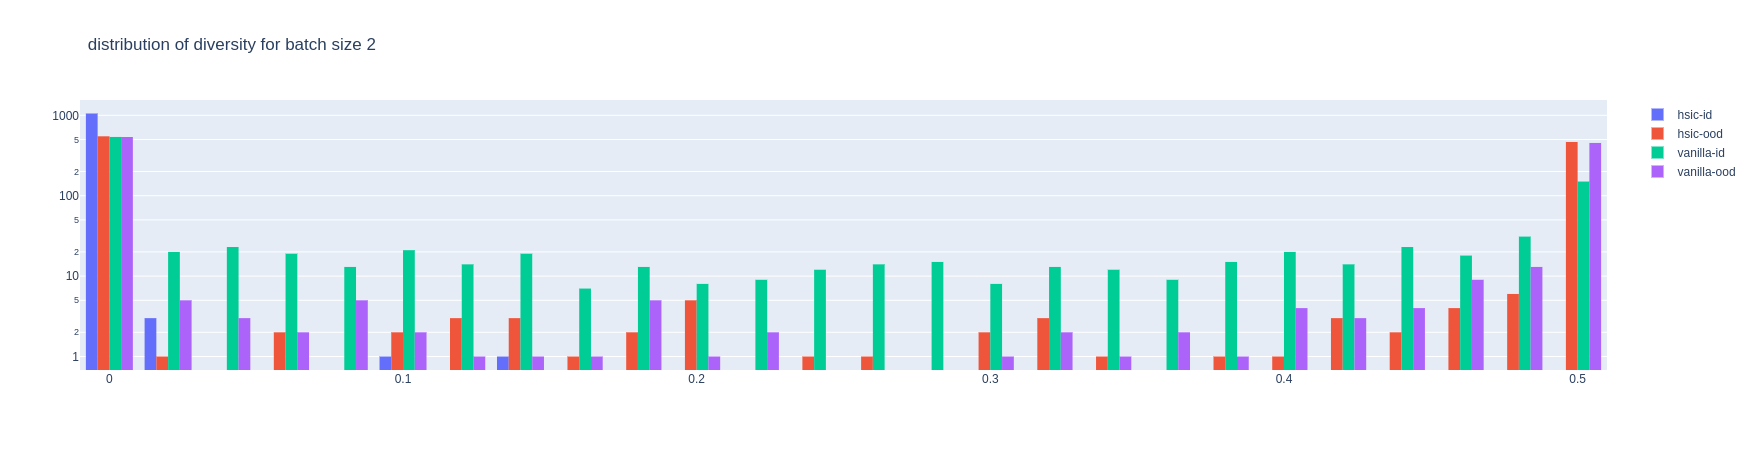

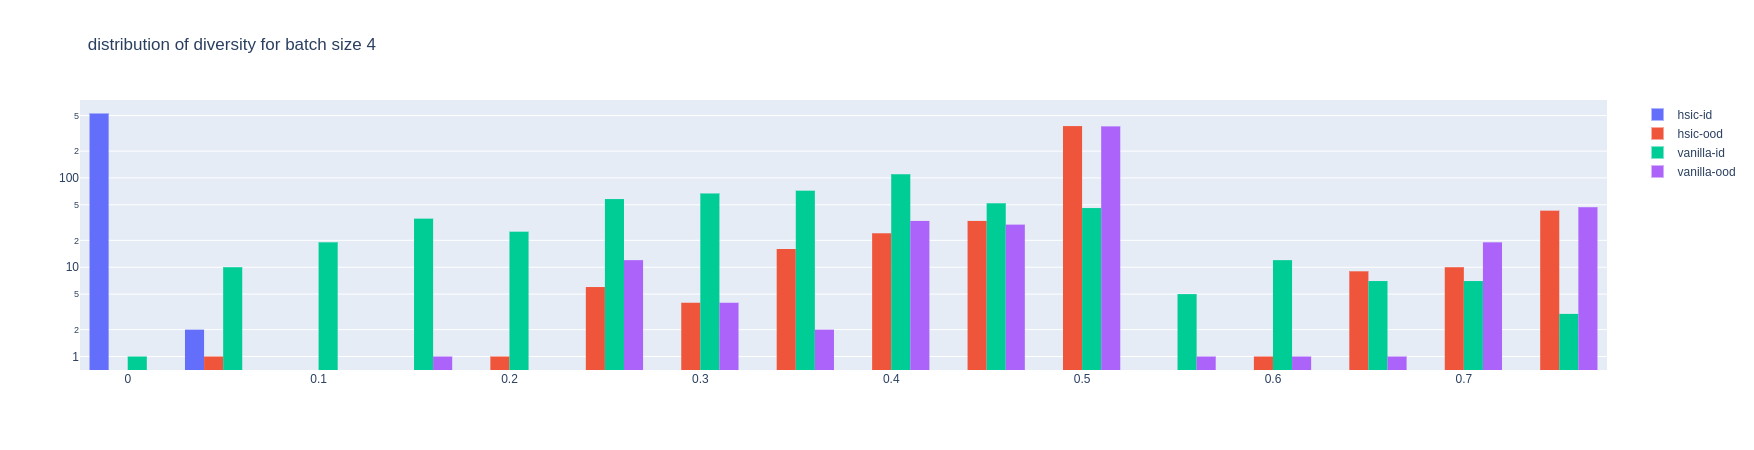

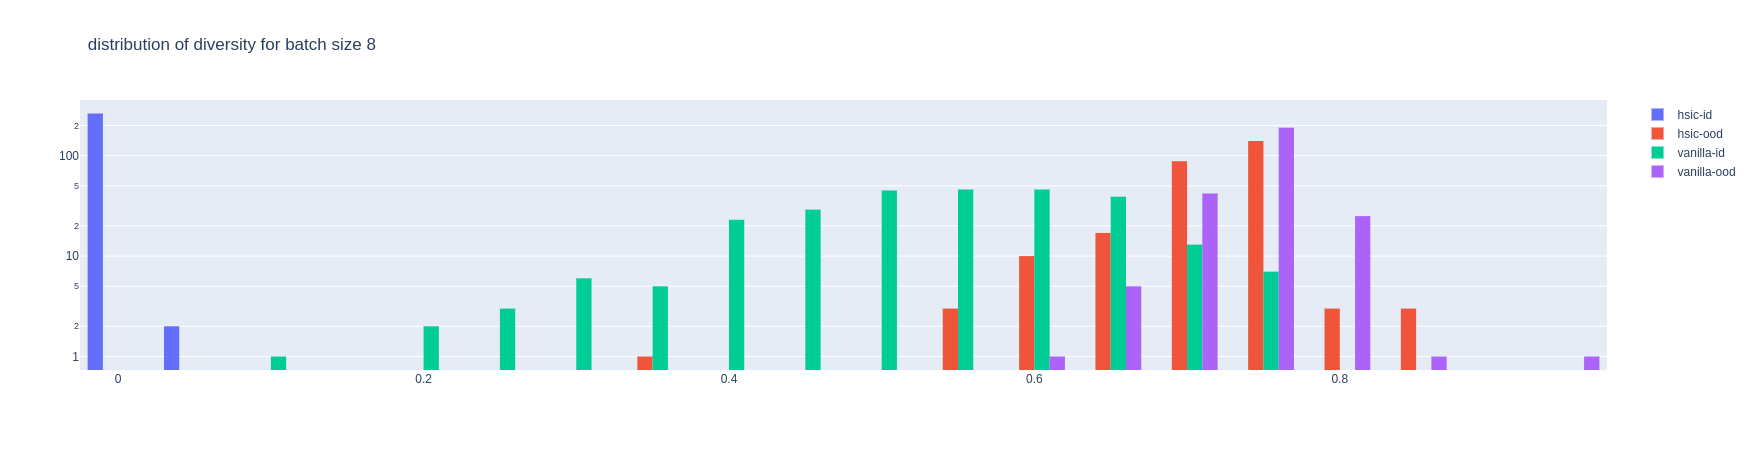

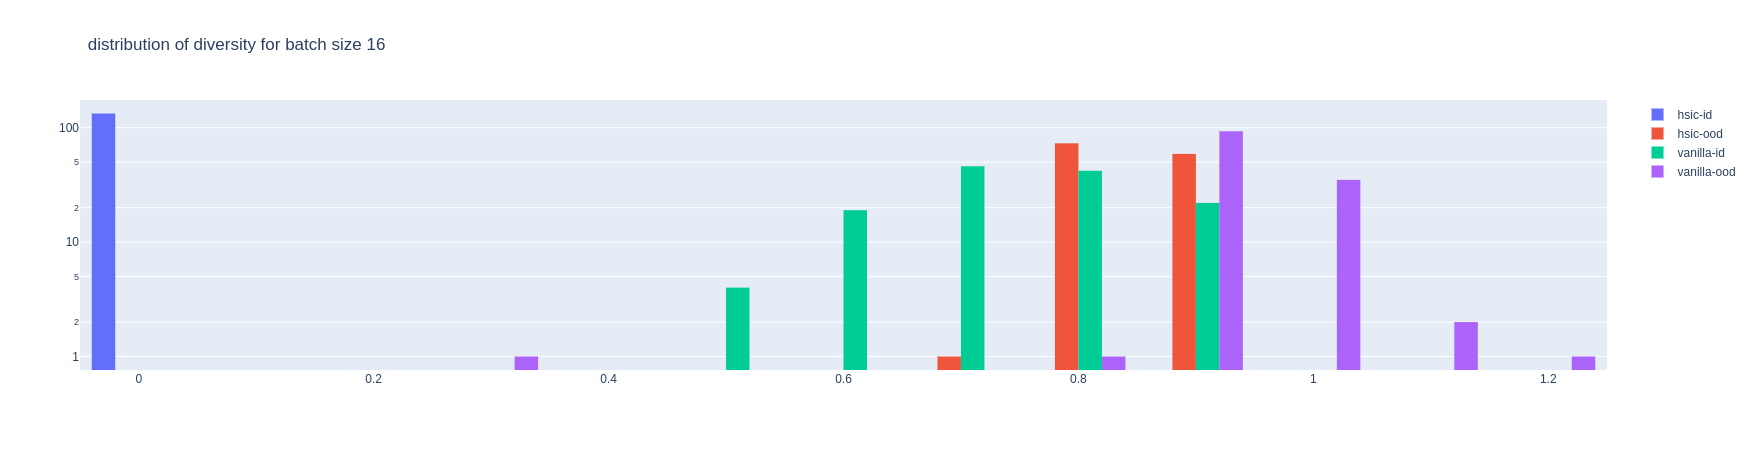

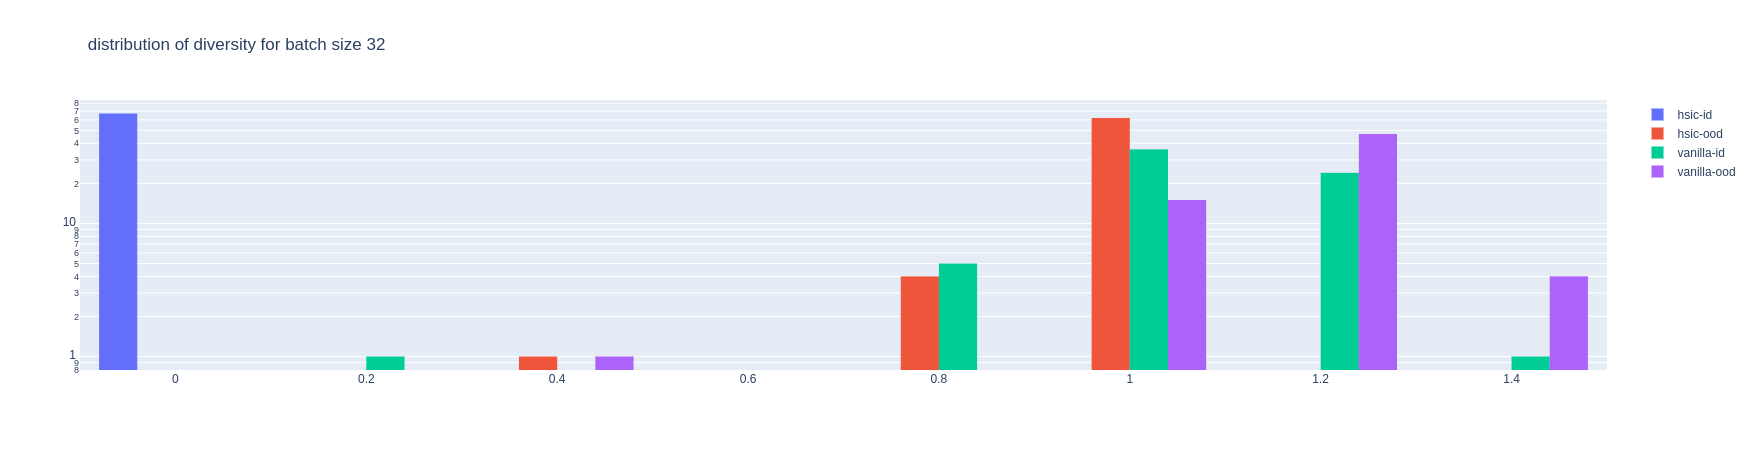

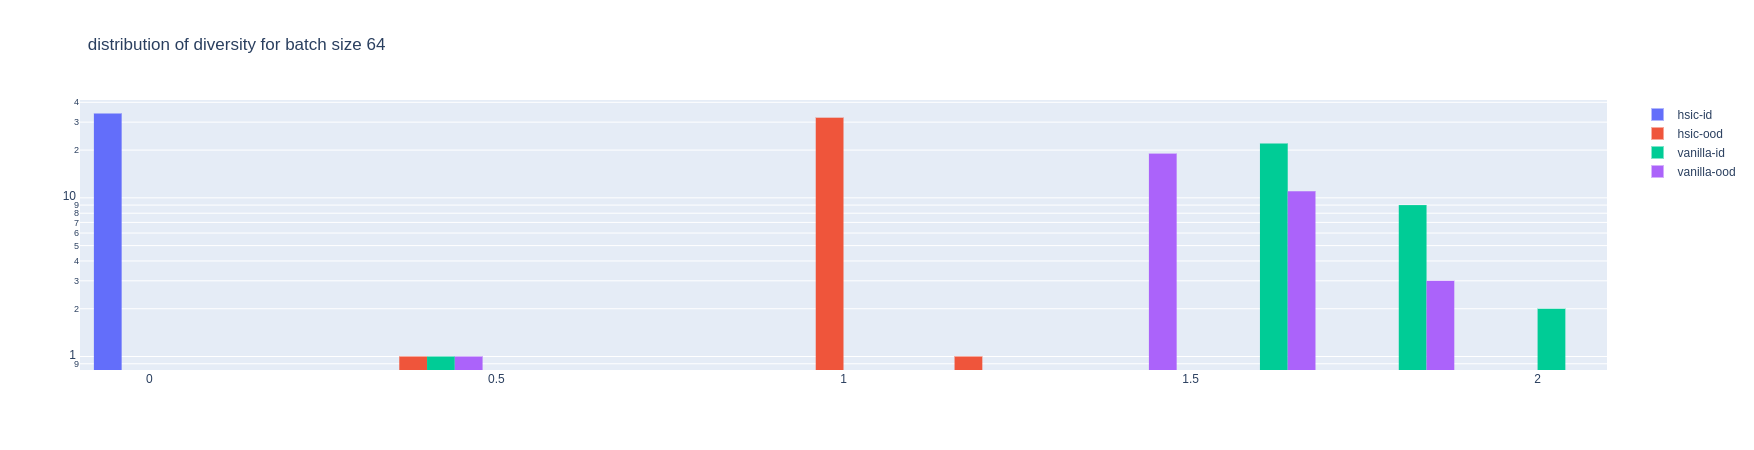

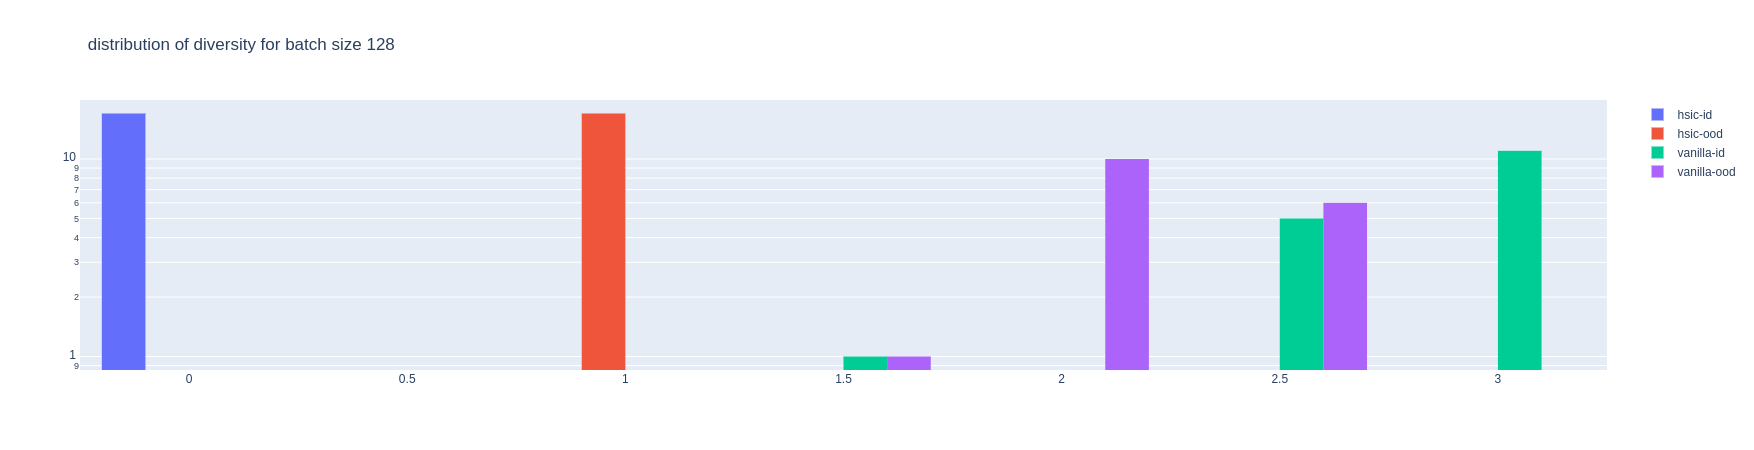

In [117]:
for batch_size in [2, 4, 8, 16, 32, 64, 128]:
    df = DF[
        (DF['lambda'] == 1) &
        (DF['label_correlation'] == 0.999) &
        (DF['indep'] == 'conditional_hsic')
    ].reset_index(drop=True)
    df_hsic = process_df(df, batch_size)

    df = DF[
        (DF['lambda'] == 0) &
        (DF['label_correlation'] == 0.999) &
        (DF['indep'] == 'conditional_hsic')
    ].reset_index(drop=True)
    df_vanilla = process_df(df, batch_size)

    df_hsic['source'] = 'hsic-' + df_hsic['source']
    df_vanilla['source'] = 'vanilla-' + df_vanilla['source']

    df = pd.concat([df_hsic, df_vanilla])
    fig = go.Figure()
    for s in df.source.unique():
        sel_df = df[df["source"] == s]
        fig.add_trace(go.Histogram(x=sel_df.diversity.to_numpy(), name=s))
    fig.update_layout(
        title=f"distribution of diversity for batch size {batch_size}",
        yaxis_type="log",
    )
    fig.show()

Model 0


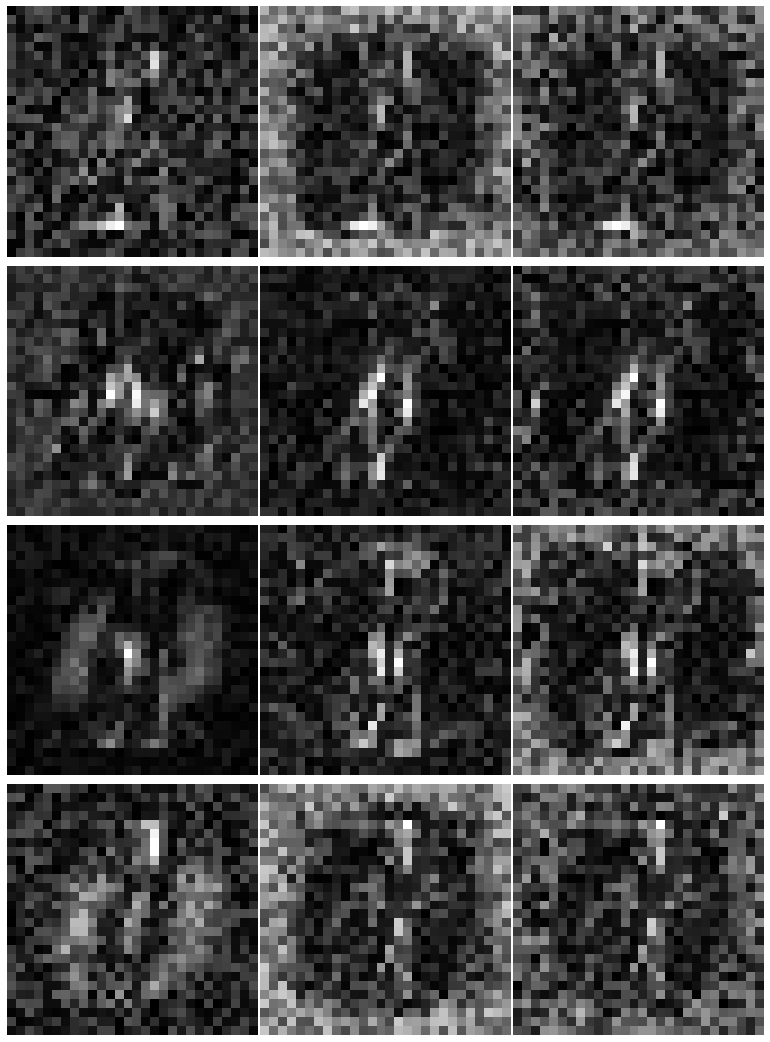

Model 1


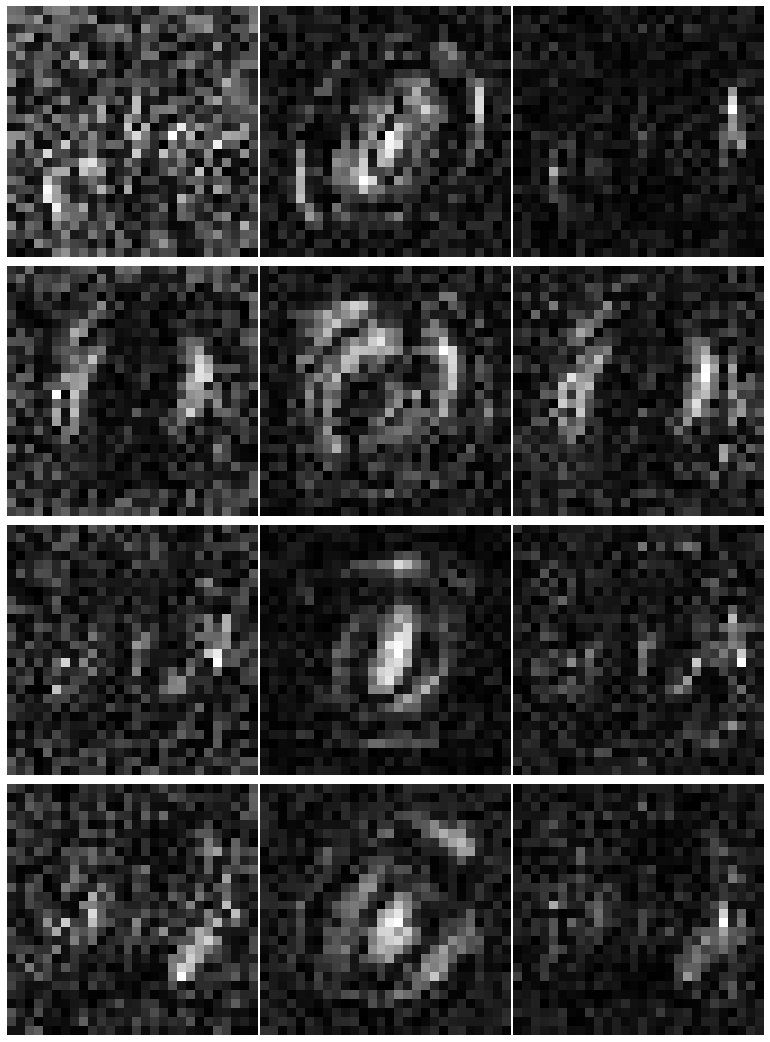

In [122]:
def visualize_weights(model: tf.keras.Model):
    (feature_extractor, logistic) = model.layers[-2:]
    [kernel, bias] = feature_extractor.get_weights()
    
    n_hidden_neurons = kernel.shape[-1]
    
    as_images = np.resize(kernel, (28, 28, 3, n_hidden_neurons))
    
    f, axarr = plt.subplots(n_hidden_neurons, 3, figsize=(15, 15))
    
    f.tight_layout()
    
    for i in range(n_hidden_neurons):
        for c in range(3):
            for_neuron = as_images[:, :, c, i]
            
            for_neuron = np.abs(for_neuron)

            axarr[i, c].imshow(for_neuron, cmap='gray')
            axarr[i, c].axis('off')

    plt.subplots_adjust(wspace=0.01, hspace=0.0001, right=10, left=9.3)
    plt.show()

print('Model 0')
visualize_weights(models[0])

print('Model 1')
visualize_weights(models[1])